In [11]:
# ====================================================
# MODEL 2: ARIMA (AutoRegressive Integrated Moving Average)
# ----------------------------------------------------
# Why ARIMA?
# ARIMA is a classic statistical model that captures trends
# and short-term temporal dependencies. It’s a good baseline
# for forecasting time series with clear patterns.
# ====================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Progress helper
def progress(msg):
    print(f"--- {msg}")

In [12]:
# Step 1: Load and prepare dataset
train = pd.read_csv('train.csv')
train['date'] = pd.to_datetime(train['date'])


In [13]:
# Step 2: Aggregate daily sales
daily_sales = train.groupby('date')['unit_sales'].sum().reset_index()
progress("Loaded and aggregated train.csv -> daily")

print("Daily range:", daily_sales['date'].min(), "to", daily_sales['date'].max())
daily_sales = daily_sales.reset_index(drop=True)
print("Daily shape:", daily_sales.shape)
print(daily_sales.head())

--- Loaded and aggregated train.csv -> daily
Daily range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
Daily shape: (1680, 2)
        date  unit_sales
0 2013-01-02       757.0
1 2013-01-03       534.0
2 2013-01-04       673.0
3 2013-01-05       898.0
4 2013-01-06       975.0


In [14]:
#STEP 3: Exploratory Data Analysis
# ====================================================
print("\nPerforming EDA...")

# Check for stationarity
print(f"Mean sales: {daily_sales['unit_sales'].mean():.2f}")
print(f"Std dev sales: {daily_sales['unit_sales'].std():.2f}")



Performing EDA...
Mean sales: 1223.43
Std dev sales: 507.34


In [15]:
#STEP 4: Train-Validation Split
# ====================================================
# Temporal split: before July 2017 for training, after for validation
train_arima = daily_sales[daily_sales['date'] < '2017-07-01']
valid_arima = daily_sales[daily_sales['date'] >= '2017-07-01']

print(f"\nTraining set: {len(train_arima)} days")
print(f"Validation set: {len(valid_arima)} days")



Training set: 1634 days
Validation set: 46 days


In [16]:
# STEP 5: Fit SARIMA Model
# ====================================================
# SARIMA parameters:
# - order (p,d,q): AR order, differencing, MA order
# - seasonal_order (P,D,Q,s): Seasonal components with period s
#
# Using (1,1,1) x (1,1,1,7) for weekly seasonality
# This means:
#   - AR(1): Uses 1 lag of the series
#   - I(1): First-order differencing
#   - MA(1): Uses 1 lag of forecast errors
#   - Seasonal period of 7 days (weekly)

print("\n" + "="*50)
print("Fitting SARIMA Model...")
print("="*50)
print("Model: SARIMA(1,1,1) x (1,1,1,7)")
try:
    start_time = time.time()
    sarima_model = sm.tsa.statespace.SARIMAX(
        train_arima['unit_sales'],
        order=(1, 1, 1),  # (p, d, q) - non-seasonal components
        seasonal_order=(1, 1, 1, 7),  # (P, D, Q, s) - seasonal components
        enforce_stationarity=False,  # Don't force stationarity
        enforce_invertibility=False  # Don't force invertibility
    )

    sarima_result = sarima_model.fit(disp=False, maxiter=200)
    train_time_arima = time.time() - start_time

    print(f"Model fitted successfully in {train_time_arima:.2f}s")

except Exception as e:
    print(f"An error occurred during model fitting: {e}")


Fitting SARIMA Model...
Model: SARIMA(1,1,1) x (1,1,1,7)
Model fitted successfully in 7.13s


In [17]:
# STEP 6: Model Summary
print("\nModel Summary:")
print(sarima_result.summary().tables[1])


Model Summary:
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2299      0.012     19.527      0.000       0.207       0.253
ma.L1         -1.0000      0.005   -193.470      0.000      -1.010      -0.990
ar.S.L7        0.0075      0.024      0.314      0.754      -0.039       0.054
ma.S.L7       -0.8811      0.013    -65.984      0.000      -0.907      -0.855
sigma2      1.422e+05   3.63e-08   3.92e+12      0.000    1.42e+05    1.42e+05


In [18]:
# STEP 7: Generate Forecasts
# ====================================================
print("\nGenerating forecasts...")

# Forecast for the validation period
forecast_arima = sarima_result.predict(
    start=len(train_arima),
    end=len(train_arima) + len(valid_arima) - 1,
    dynamic=False  # Use actual values for forecasting
)


Generating forecasts...


In [19]:
# STEP 8: Evaluate Model Performance
# ====================================================
mae_arima = mean_absolute_error(valid_arima['unit_sales'], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(valid_arima['unit_sales'], forecast_arima))

# Calculate MAPE (avoiding division by zero)
mape_denominator = valid_arima['unit_sales'].replace(0, np.nan)
mape_arima = np.mean(np.abs((valid_arima['unit_sales'] - forecast_arima) / mape_denominator)) * 100

print("\n" + "="*50)
print("SARIMA MODEL PERFORMANCE")
print("="*50)
print(f"MAE:  {mae_arima:.2f}")
print(f"RMSE: {rmse_arima:.2f}")
print(f"MAPE: {mape_arima:.2f}%")
print(f"Training Time: {train_time_arima:.2f}s")
print("="*50)


SARIMA MODEL PERFORMANCE
MAE:  338.67
RMSE: 600.55
MAPE: 19.61%
Training Time: 7.13s


In [20]:
# STEP 9: Residual Diagnostics
# ====================================================
print("\nPerforming residual diagnostics...")
residuals = sarima_result.resid

print(f"Mean of residuals: {residuals.mean():.4f}")
print(f"Std of residuals: {residuals.std():.4f}")


Performing residual diagnostics...
Mean of residuals: -5.2767
Std of residuals: 376.6474


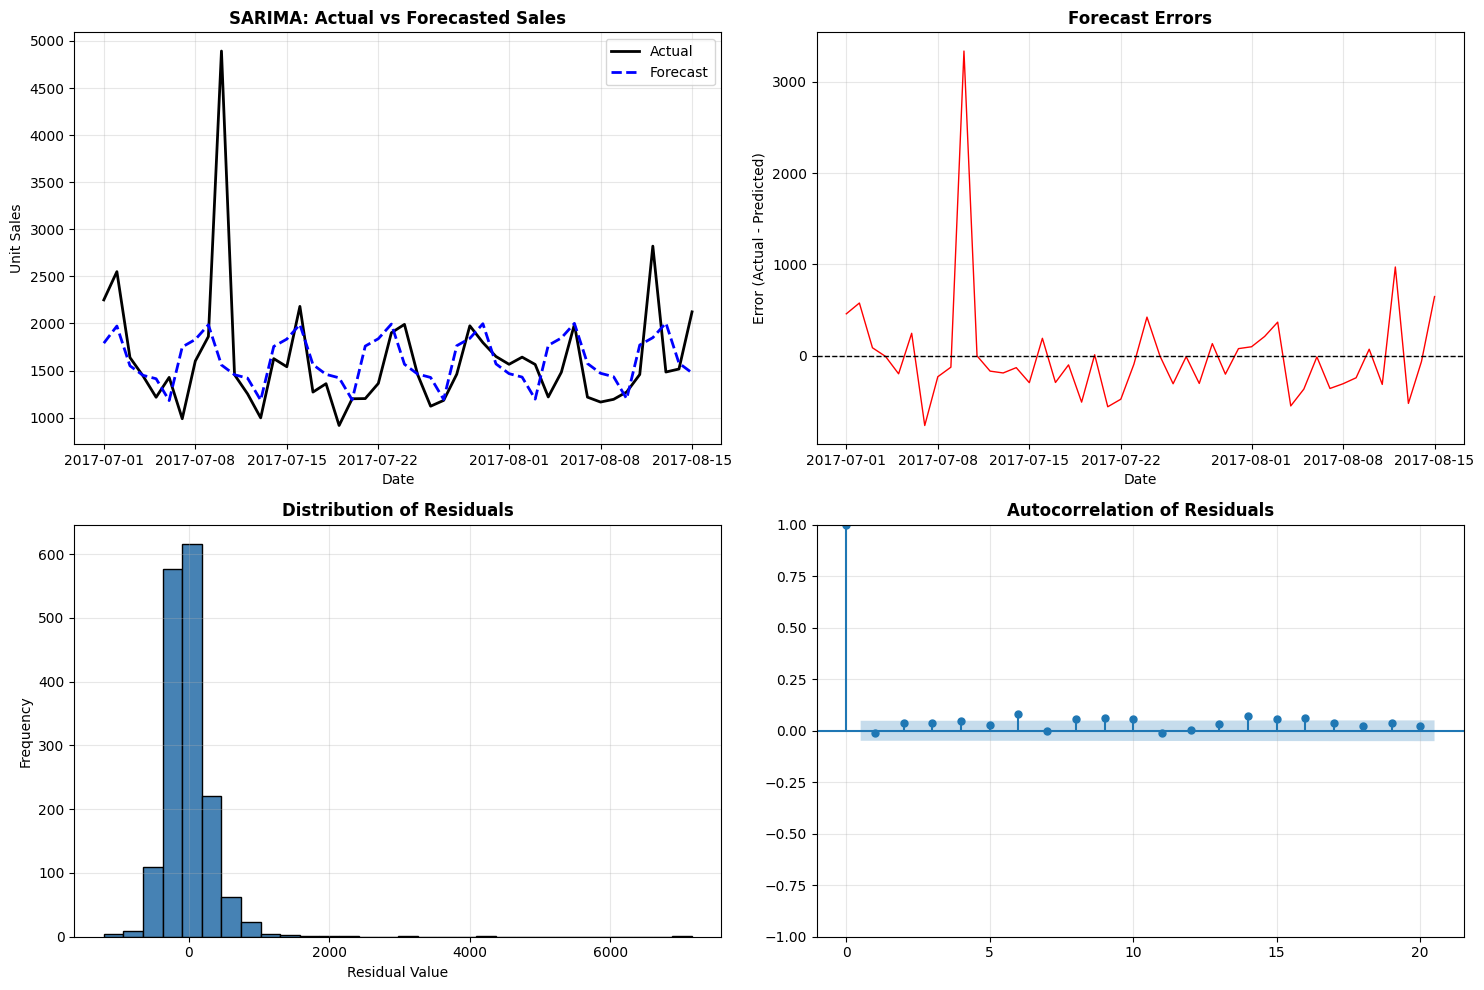

In [21]:
# STEP 10: Visualization
# ====================================================
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Actual vs Forecasted Sales
ax1 = axes[0, 0]
ax1.plot(valid_arima['date'], valid_arima['unit_sales'],
         label='Actual', color='black', linewidth=2)
ax1.plot(valid_arima['date'], forecast_arima,
         label='Forecast', color='blue', linestyle='--', linewidth=2)
ax1.set_title('SARIMA: Actual vs Forecasted Sales', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Unit Sales')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Forecast Errors
ax2 = axes[0, 1]
errors = valid_arima['unit_sales'].values - forecast_arima
ax2.plot(valid_arima['date'], errors, color='red', linewidth=1)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_title('Forecast Errors', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date')
ax2.set_ylabel('Error (Actual - Predicted)')
ax2.grid(True, alpha=0.3)

# Plot 3: Residuals Distribution
ax3 = axes[1, 0]
ax3.hist(residuals, bins=30, edgecolor='black', color='steelblue')
ax3.set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
ax3.set_xlabel('Residual Value')
ax3.set_ylabel('Frequency')
ax3.grid(True, alpha=0.3)

# Plot 4: ACF of Residuals
ax4 = axes[1, 1]
plot_acf(residuals, lags=20, ax=ax4)
ax4.set_title('Autocorrelation of Residuals', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# STEP 11: Additional Insights
# ====================================================
print("\nAdditional Insights:")
print(f"- Maximum forecast error: {np.abs(errors).max():.2f}")
print(f"- Minimum forecast error: {np.abs(errors).min():.2f}")
print(f"- Average forecast error: {np.abs(errors).mean():.2f}")

# Check if model captures seasonality
print(f"- Model captures weekly seasonality (period=7 days)")

print("\n" + "="*50)
print("SARIMA Analysis Complete!")
print("="*50)


Additional Insights:
- Maximum forecast error: 3334.23
- Minimum forecast error: 0.25
- Average forecast error: 338.67
- Model captures weekly seasonality (period=7 days)

SARIMA Analysis Complete!


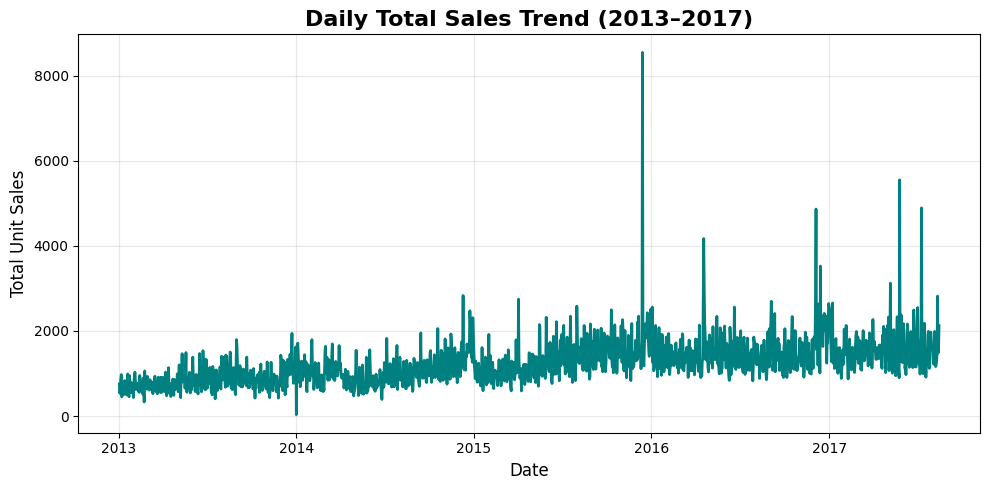

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset (simplified)
df = pd.read_csv('/content/train.csv', parse_dates=['date'])

# Aggregate total sales per day
daily_sales = df.groupby('date')['unit_sales'].sum().reset_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(daily_sales['date'], daily_sales['unit_sales'], color='teal', linewidth=2)
plt.title('Daily Total Sales Trend (2013–2017)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Total Unit Sales', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()